# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [45]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [46]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [47]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [48]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


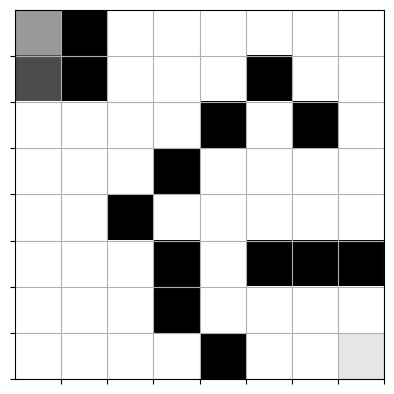

In [49]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [50]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [51]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [52]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [53]:
import datetime
import random
import numpy as np

# Define the exploration factor epsilon globally
epsilon = 1.0  # Starting with full exploration

def qtrain(model, maze, **opt):
    """
    Train a Q-learning agent on the given maze environment.

    Parameters:
    - model: Neural network model for approximating Q-values.
    - maze: Numpy array representing the maze layout.
    - opt: Optional keyword arguments for training parameters.

    Returns:
    - Total training time in seconds.
    """
    global epsilon 

    # Training parameters with default values
    n_epoch = opt.get('n_epoch', 15000)         # Number of training epochs
    max_memory = opt.get('max_memory', 1000)    # Max memory for experience replay
    data_size = opt.get('data_size', 50)        # Batch size for training

    # Start time for tracking training duration
    start_time = datetime.datetime.now()

    # Initialize the maze environment
    qmaze = TreasureMaze(maze)

    # Initialize experience replay
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # History of win (1) and lose (0) outcomes
    hsize = qmaze.maze.size // 2   # Window size for tracking recent performance
    win_rate = 0.0

    # Precompute free cells from the maze array
    free_cells = list(zip(*np.where(maze == 0)))
    if not free_cells:
        raise ValueError("No free cells available in the maze to place the agent.")

    for epoch in range(n_epoch):
        # 1. Randomly select a free cell to place the agent
        agent_cell = random.choice(free_cells)
    
        # 2. Reset the maze with the agent at the selected position
        qmaze.reset(agent_cell)
    
        # 3. Observe the initial state of the environment
        envstate = qmaze.observe()
    
        game_over = False
        n_steps = 0  # Number of steps taken in this epoch
    
        while not game_over:
            previous_envstate = envstate
    
            # 4. Choose an action using epsilon-greedy policy
            if random.uniform(0, 1) < epsilon:
                # Exploration: choose a random action (integer)
                action = random.choice([0, 1, 2, 3])  # Integer values for LEFT, UP, RIGHT, DOWN
            else:
                # Exploitation: choose the best action based on current Q-values
                state_input = np.expand_dims(previous_envstate, axis=0)  # Add batch dimension
                q_values = model.predict(state_input, verbose=0)[0]
                action_index = np.argmax(q_values)
                action = int(action_index)  # Convert to integer
    
            # 5. Take the action in the environment
            envstate, reward, game_status = qmaze.act(action)
    
            # 6. Store the transition in experience replay (ensure action is an integer)
            episode = (previous_envstate, int(action), reward, envstate, game_status)
            experience.remember(episode)
    
            n_steps += 1
    
            # 7. Check if the game has ended
            if game_status != 'playing':
                game_over = True
                # Update win history
                if game_status == 'win':
                    win_history.append(1)
                else:
                    win_history.append(0)
    
        # 8. Train the neural network model using experience replay
        inputs, targets = experience.get_data(data_size=data_size)
    
        if inputs is not None and targets is not None:
            # Fit the model on the batch
            history = model.fit(inputs, targets, epochs=1, verbose=0)
            loss = history.history['loss'][0]
        else:
            loss = 0.0  # No training if no data is available


        # 9. Calculate the win rate over the recent history window
        if len(win_history) >= hsize:
            recent_wins = win_history[-hsize:]
            win_rate = sum(recent_wins) / hsize
        else:
            win_rate = sum(win_history) / len(win_history) if win_history else 0.0

        # 10. Print the epoch statistics
        elapsed_time = datetime.datetime.now() - start_time
        formatted_time = format_time(elapsed_time.total_seconds())
        template = (
            "Epoch: {:05d}/{} | Loss: {:.4f} | Steps: {:d} | Wins: {:d} | "
            "Win Rate: {:.3f} | Time Elapsed: {}"
        )
        print(template.format(
            epoch + 1, n_epoch, loss, n_steps, sum(win_history), win_rate, formatted_time
        ))

        # 11. Decay epsilon to reduce exploration over time
        if win_rate > 0.9:
            epsilon = max(epsilon * 0.995, 0.05)  # Decay rate and minimum epsilon

        # 12. Early stopping if recent performance is perfect and model passes completion check
        if len(win_history) >= hsize and sum(win_history[-hsize:]) == hsize:
            if completion_check(model, qmaze):
                print(f"Reached 100% win rate at epoch: {epoch + 1}")
                break

    # Total training time
    total_time = datetime.datetime.now() - start_time
    total_seconds = total_time.total_seconds()
    formatted_total_time = format_time(total_seconds)

    print(
        f"Training completed. "
        f"Total Epochs: {epoch + 1}, "
        f"Max Memory: {max_memory}, "
        f"Batch Size: {data_size}, "
        f"Total Time: {formatted_total_time}"
    )
    return total_seconds

def format_time(seconds):
    """
    Convert seconds to a human-readable time format.

    Parameters:
    - seconds: Time in seconds.

    Returns:
    - A string representing the time in seconds, minutes, or hours.
    """
    if seconds < 60:
        return f"{seconds:.1f} seconds"
    elif seconds < 3600:
        minutes = seconds / 60.0
        return f"{minutes:.2f} minutes"
    else:
        hours = seconds / 3600.0
        return f"{hours:.2f} hours"


## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

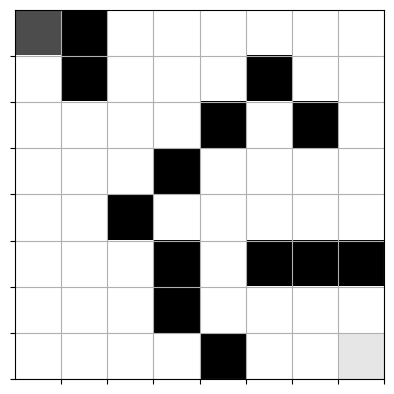

In [54]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [ ]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

C:\Users\ahero\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch: 00001/15000 | Loss: 0.0333 | Steps: 1 | Wins: 0 | Win Rate: 0.000 | Time Elapsed: 2.3 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch: 00002/15000 | Loss: 0.0008 | Steps: 1 | Wins: 0 | Win Rate: 0.000 | Time Elapsed: 2.8 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch: 00003/15000 | Loss: 0.0029 | Steps: 1 | Wins: 0 | Win Rate: 0.000 | Time Elapsed: 3.4 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [ ]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

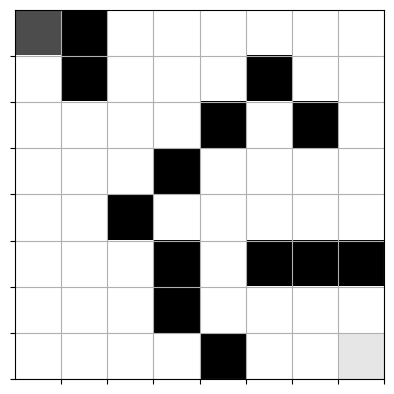

In [56]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.